In [1]:
from osgeo import gdal
import numpy as np
import pandas as pd
import rasterio as rio
import geoviews as gv
import holoviews as hv
from holoviews.operation.datashader import datashade, aggregate
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

#makes jupyter notebook screen wider
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:80% !important; }</style>"))

/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:


#Import the data

#Read a raster
Test_data = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/"
Test = gdal.Open(Test_data + "/Mandakini.bil")#Get raster data
M_DEM = Test.ReadAsArray()

#Read stream data
name = "Mandakini_fullProfileMC_forced_0.45_3_1258909000_10_80_281_for_Arc.csv" #Set file name
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/" #Set path to data

#for csv files
#data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['id', 'x', 'y', 'chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])
#for tree files
#data = np.genfromtxt((path+name), delimiter=' ', skip_header=1, names=['chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])

#load csv file as pandas dataframe
df = pd.read_csv(path+name)

##load Raster data
newpath = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/'
raster_data = rio.open(newpath+'Mandakini.bil')



# define catagorized dataframe column
#path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/Mandakini_fullProfileMC_forced_0.45_3_1258909000_10_80_281_for_Arc.csv'
#df = pd.read_csv(path, usecols=['x', 'y', 'flow_distance', 'elevation', 'chi'])
#df['elevation_cat'] = pd.cut(df['elevation'], bins=[0, 1000, 1500, 2700], labels=['low', 'mid', 'high']).astype('category')

from interactive_profiler import define_boundaries

x_range, y_range = define_boundaries(df, 10000)

x0 = min(x_range)
y0 = min(y_range)
x1 = max(x_range)
y1 = max(y_range)
test = (x0, y0, x1, y1)

INFO:bokeh.core.state:Session output file 'Interactive_profile.html' already exists, will be overwritten.
ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='701aeb8e-f4a9-486a-9b8e-955629247a6a', ...)]
ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='d21dc2e7-6de0-4b99-8fcc-45969c6da1de', ...)]
ERROR:/Users/bmelosh/anaconda2/envs/geospatial/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: colors [renderer: GlyphRenderer(id='f723e72b-1523-43a8-8f3a-c0f5c93a1a19', ...)]


In [5]:
import holoviews as hv
import geoviews as gv
from bokeh.models import ColumnDataSource
hv.notebook_extension()

dataset = gv.Dataset(df, kdims=['x', 'y'], vdims=['elevation', 'chi', 'flow_distance'])
shade_defaults = dict(x_range=x_range, y_range=y_range, x_sampling=100, y_sampling=100, width=1200, height=660)

shaded = datashade(hv.Points(dataset),  cmap=inferno, aggregator=ds.mean('elevation'), **shade_defaults)

ras*shaded

NameError: name 'df' is not defined

In [187]:
#quickref  #For a quick reference of jupyter notebook shortcuts.


In [25]:
#may 9th, using holoviews to plot up raster and points

import holoviews as hv
import geoviews as gv
from cartopy import crs


stream = gv.Dataset(df, kdims=['x', 'y', 'elevation', 'chi'])

streams = stream.to(gv.Points, kdims=['x', 'y'],
                    vdims=['elevation', 'chi'], crs=crs.PlateCarree())

%output backend='bokeh'
%opts Overlay [width=600 height=300 xaxis=None yaxis=None] 
%opts Points (size=0.005 cmap='inferno') [tools=['hover'] color_index=2]




:Dataset   [x,y,elevation,chi]   (id,channel_number,receiver_channel,node_on_reciever_channel,node,row,column,flow_distance,drainage_area,n_data_points,m_mean,m_st_dev,m_std_err,b_mean,b_st_dev,b_std_err,DW_mean,DW_st_dev,DW_std_err,fitted_elev_mean,fitted_elev_st_dev,fitted_elev_std_err)

In [39]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno


def create_base_plot():
    
    # data is in meters
    xmin = 314000 
    ymin = 3368000
    xmax = 332000
    ymax = 3380000
    
    #Define plot canvas area
    cvs = ds.Canvas(plot_width=900,
                    plot_height=600,
                    x_range=(xmin, xmax),
                    y_range=(ymin, ymax))
    
    #
    agg = cvs.points(df, 'x', 'y', ds.mean('elevation'))
    img = tf.shade(agg, cmap=inferno, how='log')
    fig = Figure(x_range=(xmin, xmax),
                 y_range=(ymin, ymax),
                 plot_width=900,
                 plot_height=600,
                 tools='')
    
    fig.background_fill_color = 'black'
    fig.toolbar_location = None
    fig.axis.visible = False
    fig.grid.grid_line_alpha = 0
    fig.min_border_left = 0
    fig.min_border_right = 0
    fig.min_border_top = 0
    fig.min_border_bottom = 0

    fig.image_rgba(image=[img.data],
                   x=[xmin],
                   y=[ymin],
                   dw=[xmax-xmin],
                   dh=[ymax-ymin])
    return fig, (xmin, ymin, xmax, ymax), agg

fig, extent, datashader_agg = create_base_plot()


In [36]:
#may 8th , monday, plotting coordinates and datashader rasters
cvs = ds.Canvas(plot_width=900,
                    plot_height=600,
                    x_range=(xmin, xmax),
                    y_range=(ymin, ymax))


%time tf.shade(cvs.points(df,'x','y'))
glyph = ds.glyphs.Point('x', 'y')

from datashader import reductions
reduction = reductions.count()

from datashader.core import bypixel
agg = bypixel(df, cvs, glyph, reduction)



NameError: name 'xmin' is not defined

In [30]:
#Best way to display stream as a datashader image, although this is probably not the way to go.


#tf.shade(cvs.points(df, 'x', 'y', agg=reductions.mean('elevation')))

# cvs = ds.Canvas(plot_width=900, plot_height=900, x_range=(314000,332000),y_range=(3368000,3380000))
# aggr = reductions.mean('elevation')
# img = cvs.points(df, 'x', 'y',agg=aggr)
# tfimg = tf.shade(img, cmap=[(230,230,0), "orangered", "#300030"])
# tf.spread(tfimg)




In [30]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import Figure


bp.output_notebook()

#Bokeh figure, set data source
source=bp.ColumnDataSource(df)


#p = bp.figure(tools='pan,wheel_zoom,reset', x_range=x_range, y_range=y_range)

#p.circle(pdata['x'], pdata['y'], source=source, color='red', size=6)

#setting interactive plot
#my_hover = HoverTool()
#my_hover.tooltips = [('Elevation (m)', '@elevation'), ('Chi (X)', '@chi')]
#p.add_tools(my_hover)



#function to create datashader image
def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.reductions.mean('elevation'))
    img = tf.shade(agg)
    return tf.spread(img)#, threshold=0.80)





p = bp.figure(x_range=x_range, y_range=y_range)
p.circle(df['x'][0],df['y'][0], source=source, color='red', size=20)


#interactive image for the raster
#InteractiveImage(p, basic_raster)



#image_callback((314000,332000),(3368000,3380000), 2000, 2000)

#interactive image for the stream
InteractiveImage(p, image_callback)

Loading BokehJS ...

:Overlay
   .Raster.I :Raster   [x,y]   (z)
   .Points.I :Points   [x,y]
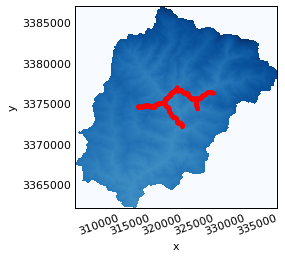

In [31]:
from osgeo import gdal
import holoviews as hv
import geoviews as gv
import pandas as pd
import cartopy as crs
hv.notebook_extension()

#importing the data
name = "Mandakini_fullProfileMC_forced_0.45_3_1258909000_10_80_281_for_Arc.csv" #Set file name
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/" #Set path to data
df = pd.read_csv(path+name)
Test_data = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/"
Test = gdal.Open(Test_data + "/Mandakini.bil")#Get raster data
M_DEM = Test.ReadAsArray()

from interactive_profiler import define_boundaries
x_range, y_range = define_boundaries(df, 10000)

x0 = min(x_range)
y0 = min(y_range)
x1 = max(x_range)
y1 = max(y_range)

points = df['x'],df['y']
stream = hv.Points(points)









%opts Raster [xrotation=20] Points (color='r')[xrotation=20]

kdims = ['x', 'y']

ras = hv.Raster(M_DEM)(style={'cmap':'Blues'})

ras.extents = (x0, y1, x1, y0) #something is backwards in my "Define boundaries" function
stream.extents =(x0,y1,x1,y0)


ras*stream


In [32]:
xr_dataset = gv.Dataset(M_DEM, crs=crs.PlateCarree(),
                        kdims=['latitude','longitude'],
                        vdims=['elevation'])
xr_dataset

ras2 = xr_dataset.to(gv.Image, ['longitude', 'latitude']) * gf.coastline
ras2[::2]

AttributeError: 'module' object has no attribute 'PlateCarree'

Loading BokehJS ...